# Primary Grid to Dualgrid Conversion

## To Do:
- Primary grid must be stored as tuple list 
- Only pointers in dualgrid functions!


## Interior Dualgrid:
Each dualgrid cell is stored as list array. Dualcell loop starts always with adjacent primary element with lowest x- and y-values.
The loop moves from this element centroid to the centroid of an adjacent edge to the next element centroid and so on.
If a node has $N$ adjacent elements, there will be $N$ element centroids and $N$ edge centroids  in the dualcell list. So the loop ends, if len(duallist) equals $2N$.

    1) Start at interior node $i$

    2) Move to adjacent element with lowest x- and y-values and append element to dualcell list.

    3) Grab the edges of this element, that are adjacent to node $i$ and add the edge, that is not yet in the current dualcell list. If none of these edges is already part of the current dualcell list, append the one with the lowest x- and y-centroid.

    4) Move to the adjacent element of this edge.

In [103]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np



def get_edge_to_triangle_connection(T):
    '''
    Function to determine the neighbouring elements of an edge in a triangular mesh
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        edges: dictionary - keys are two node indices, that define a triangles edge
               every key has a list of two values, which are the adjacent triangles 
               to the edge. If the last value is -1, the edge is located at the boundary
               
    '''
    E2T = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all current edges
        for iE in range(3):
            edge = (tri[iE], tri[(iE+1)%3])
            
            # Check if edge is already in dictionary
            if (edge in E2T) or (edge[::-1] in E2T):
                try:
                    E2T[edge][1] = tuple(tri)#iTri
                except:
                    E2T[edge[::-1]][1] = tuple(tri) #iTri
            else:
                E2T.update({edge:[tuple(tri), -1]})
    return E2T
            
    
def get_node_to_triangle_connection(T):
    '''
    Function to determine the triangles, that are adjacent to a node in the triangular mesh.
    
    Input:
        T: 3 x N dimensional list with triangle node indices for mesh with N 
           triangles
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent triangular elements

    '''
    nodes = {}
    # Loop over all triangles
    for iTri, tri in enumerate(T):
        # Loop over all triangle nodes
        for n in tri:
            if n in nodes:
                nodes[n].append(tuple(tri))
            else:
                nodes.update({n: [tuple(tri)]})
    return nodes
            
            
def get_node_to_edge_connection(E2T):
    '''
    Function determines which edges are adjacent to the mesh nodes
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output:
        nodes: dictionary - keys are the mesh nodes - their values are the indices of their
               adjacent mesh-edges
    
    '''
    nodes = {}
    # Loop over all edges
    for edg in E2T:
        # Loop over all nodes of the respective edge
        for n in edg:
            if n in nodes:
                nodes[n].append(edg)
            else:
                nodes.update({n: [edg]})
    return nodes


def get_triangle_to_triangle_connection(E2T):
    '''
    This function creates the connectivity between triangular elements
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: T2T - dictionary - keys are the triangles in node connectivity format
            and values are a list with three entries, that have the neighbouring
            triangle node connectivities or -1 if that edge is at the boundary
    '''
    T2T = {}
    for edg in E2T:
        # Get the triangles that are already found, in "set()" format
        keys = [set(k) for k in T2T.keys()]
        # Check both adjacent triangles to current face 
        for itri, tri in enumerate(E2T[edg]):
            # Boundary edges will have set -1 as second triangle
            if (tri == -1):
                continue   
            # check if triangle exists - if not, add triangle to T2T
            if set(tri) not in keys:
                T2T.update({tri: [-1, -1, -1]})    
            # Check, which indice "edg" has in the current triangle
            # This triangle will then get the neighbor triangle at the
            # same position in the T2T-list
            indEdg = 0
            for iE in range(3):
                edgTri = set((tri[iE], tri[(iE+1)%3]))
                if (set(edg) == edgTri):
                    T2T[tri][indEdg] = E2T[edg][(itri+1)%2]
                indEdg += 1  
    return T2T


def get_node_to_node_connection(T):
    '''
    This function determines the direct neighboring nodes for each node of the primary mesh
    '''
    N2N = {}
    
    # Loop over each triangle
    for tri in T:
        # Loop over all nodes of current triangle
        for i in range(len(tri)):
            # Check if current node has already been added to N2N
            # If not, append it to the dictionary and add the adjacent nodes of current
            # triangle as values
            if tri[i] not in N2N.keys(): N2N.update({tri[i]: [tri[(i+1)%len(tri)], tri[(i+2)%len(tri)]]})
            # If yes, check weather the other nodes of the current triangle are already
            # values of this node in N2N
            else:
                if tri[(i+1)%len(tri)] not in N2N[tri[i]]: N2N[tri[i]].append(tri[(i+1)%len(tri)])
                if tri[(i+2)%len(tri)] not in N2N[tri[i]]: N2N[tri[i]].append(tri[(i+2)%len(tri)])
                
    return N2N
        

def get_boundary_nodes(E2T):
    '''
    This function determines, which nodes are located at the boundary
    
    Input: edge_to_triangle-dictionary from "get_edge_to_triangle_connection"-function
    
    Output: list of node indices, that are adjacent to a boundary
    '''
    nodes = []
    for edg in E2T:
        if E2T[edg][1] == -1:
            nodes.append(edg[0])
    return nodes


def get_interior_nodes(bdry_nodes, N):
    '''
    This function determines, which nodes are located in the interior of the domain
    
    Input: bdry_nodes - list with indices of nodes that are adjacent to a boundary
           N - length of global node array
    
    Output: list of node indices, that are not adjacent to a boundary
    '''
    nodes = []
    for i in range(N):
        if i not in bdry_nodes:
            nodes.append(i)
    return nodes


def eval_edge_centroid(x, y, edge):
    '''
    This function computes the centroid of an edge (i0,i1)
    '''
    xc, yc = 0.0, 0.0
    for i in range(2):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/2.0, yc/2.0))

def eval_triangle_centroid(x, y, triangle):
    '''
    This function computes the centroid of a triangle (i0,i1,i2)
    '''
    xc, yc = 0.0, 0.0
    for i in range(3):
        xc += x[triangle[i]]
        yc += y[triangle[i]]
    return ((xc/3.0, yc/3.0))
    

def get_interior_dual_median_cell(iNode, x, y, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity list around an interior node "iNode"
    The connectivity list is of the following type:
    [(v0,v1,v2), (v0,v1), (v0,v1,v2),(v0,v1),...]
      \      /    \   /
        node       node
      indices      indices
      of element   of edge
    '''
    
    adjEdge      = N2E[iNode] # all edges that are adjacent to this node
    adjTri       = N2T[iNode] # all triangles that are adjacent to this node
    adjEdge_keys = [set(edg) for edg in adjEdge] # set array of adjacent edges
    N            = len(adjTri) # Number of adjacent elements
    
    dualcell     = [adjTri[0]] # The dualcell-list - start with first triangle in "adTri" 
    dualkeys     = [set(dc) for dc in dualcell] # array of keys with already appended elements / edges
    
    maxIter = 0 # Iteration counter  
    while (len(dualcell) < 2*N) and (maxIter < 3*N):
        maxIter += 1
        # Loop over all edges of the last element in dualcell-list
        for iEdge in range(3):
            edge = set(( dualcell[-1][iEdge], dualcell[-1][(iEdge+1)%3] ))
            # Check if this edge is part of the adjacend edges to node 
            # and if this edge has already been appended to dualcell list
            if (edge not in dualkeys) and (edge in adjEdge_keys):
                # Find current edge in "adjEdge" list
                for adEdge in adjEdge:
                    if (edge == set(adEdge)):
                        # Find adjacent triangle to this edge, that is not the
                        # current triangle
                        if (set(dualcell[-1]) == set(E2T[adEdge][0])):
                            nextElem = E2T[adEdge][1]
                        else:
                            nextElem = E2T[adEdge][0]
                        dualcell.append(adEdge)
                        # Add new keys
                        dualkeys.append(set(dualcell[-1]))
                        if (len(dualcell)<2*N):
                            dualcell.append(nextElem)
                            # Add new keys
                            dualkeys.append(set(dualcell[-1]))
                        continue
                        
                if (len(dualcell)>= 2*N):
                    break
    return dualcell  
    
    
def get_boundary_dual_median_cell(iNode, x, y, N2T, N2E, E2T):
    '''
    This function creates the dual-median connetivity list around an boundary node "iNode"
    The connectivity list is of the following type:
    [(v0),(v0,v1),(v0,v1,v2), (v0,v1), (v0,v1,v2),(v0,v1),...]
      \ /  \   /    \    /
  boundary  node     node
     node   indices  indices
            of edge  of element
    '''
    adjEdge      = N2E[iNode] # all edges that are adjacent to this node
    adjTri       = N2T[iNode] # all triangles that are adjacent to this node
    adjEdge_keys = [set(edg) for edg in adjEdge] # set array of adjacent edges
    N            = len(adjTri) # Number of adjacent elements
    
    dualcell     = [] # The dualcell-list
    # Add this node to the dualcell
    dualcell.append(tuple([iNode]))
    # Start with first edge in "adjEdge", which is a boundary edge
    for adEdge in adjEdge:
        if E2T[adEdge][1] == -1:
            dualcell.append(adEdge)
            break
    # Add adjacent element to this boundary edge
    dualcell.append(E2T[dualcell[-1]][0])
    dualkeys     = [set(dc) for dc in dualcell] # array of keys with already appended elements / edges
    
    maxIter = 0 # Iteration counter  
    while (len(dualcell) < 2*N+2) and (maxIter < 3*N):
        maxIter += 1
        # Loop over all edges of the last element in dualcell-list
        for iEdge in range(3):
            edge = set(( dualcell[-1][iEdge], dualcell[-1][(iEdge+1)%3] ))
            # Check if this edge is part of the adjacend edges to node 
            # and if this edge has already been appended to dualcell list
            if (edge not in dualkeys) and (edge in adjEdge_keys):
                # Find current edge in "adjEdge" list
                for adEdge in adjEdge:
                    if (edge == set(adEdge)):
                        # Find adjacent triangle to this edge, that is not the
                        # current triangle
                        if (set(dualcell[-1]) == set(E2T[adEdge][0])):
                            nextElem = E2T[adEdge][1]
                        else:
                            nextElem = E2T[adEdge][0]
                        dualcell.append(adEdge)
                        # Add new keys
                        dualkeys.append(set(dualcell[-1]))
                        if (len(dualcell)<2*N+1):
                            dualcell.append(nextElem)
                            # Add new keys
                            dualkeys.append(set(dualcell[-1]))
                        continue
                        
                if (len(dualcell)>= 2*N+2):
                    break
                    
    return dualcell


def get_triangle_id_list(T):
    '''
    This function sets up a dictionary for a given triangulation T, whereas the triangle
    node connectivity is key and its element-index in the primary mesh is value
    '''
    T_ID = {}
    for iTri, tri in enumerate(T):
        T_ID.update({T[iTri] : iTri})
    return T_ID

def get_edge_id_list(E2T):
    '''
    This function sets up a dictionary for a given edge-to-triangle list E2T, whereas the edge to
    node connectivity is key and its edge-index in the E2T list is value
    '''
    E_ID = {}
    for iEdg, edg in enumerate(E2T):
        E_ID.update({edg : iEdg})
    return E_ID

def get_bdry_node_id_list(bdry_nodes):
    '''
    This function sets up a dictionary for a given boundary node list, whereas the edge to
    node connectivity is key and its edge-index in the E2T list is value
    '''
    BN_ID = {}
    for iNode, node in enumerate(bdry_nodes):
        BN_ID.update({node : iNode})
    return BN_ID


def compute_element_centroid(x,y,element):
    '''
    This function computes the geometrical centroid of an 2D geometric object
    '''
    N_vert = len(element)
    xc, yc = 0.0, 0.0
    for i in range(N_vert):
        xc += x[element[i]]
        yc += y[element[i]]
        
    return (xc/N_vert, yc/N_vert)
        
    
def create_dual_vertices(x, y, T_ID, E_ID, bdry_nodes):
    '''
    This function creates a new x and y array vertices,
    which are used to define the median-dual mesh.
    The vertices are arranged in the following way:
    First all triangle centroids are stored, then all edge 
    centroids and finally all boundary nodes.
    '''
    x_dual, y_dual = [], []
    for tri in T_ID:
        (xc,yc) = compute_element_centroid(x,y,tri)
        x_dual.append(xc)
        y_dual.append(yc)

    for edg in E_ID:
        (xc,yc) = compute_element_centroid(x,y,edg)
        x_dual.append(xc)
        y_dual.append(yc)

    for bNd in bdry_nodes:
        x_dual.append(x[bNd])
        y_dual.append(y[bNd])
    
    return (x_dual, y_dual)


def create_interior_dual_adjacency_list(x, y, T_ID, E_ID, N2T, N2E, E2T, intr_nodes):
    '''
    This function creates the adjacency list for the interior elements of the
    median-dual mesh
    '''
    # Create dualmesh adjacency list for interor elements
    intr_cells =[]
    N_T_ID = len(T_ID)
    N_E_ID = len(E_ID)

    for iNode in intr_nodes:
        # determine current cell adjacency list in primary grid indices format
        intr_cell = get_interior_dual_median_cell(iNode, x, y, N2T, N2E, E2T)
        # Convert to dualmesh indices format
        intr_cell_dual = []
        for iCell in intr_cell:
            if (len(iCell) == 3): 
                intr_cell_dual.append(T_ID[iCell])
            if (len(iCell) == 2):
                intr_cell_dual.append(E_ID[iCell] + N_T_ID)
        intr_cells.append(intr_cell_dual)
        
    return intr_cells


def create_boundary_dual_adjacency_list(x, y, T_ID, E_ID, BN_ID, N2T, N2E, E2T, bdry_nodes):
    '''
    This function creates the adjacency list for the boundary elements of the
    median-dual mesh
    '''
    # Create dualmesh adjacency list for boundary elements
    bdry_cells = []
    N_T_ID = len(T_ID)
    N_E_ID = len(E_ID)
    for iNode in bdry_nodes:
        # determine current cell adjacency list in primary grid indices format
        bdry_cell = get_boundary_dual_median_cell(iNode, x, y, N2T, N2E, E2T)
        # Convert to dualmesh indices format
        bdry_cell_dual = []
        for iCell in bdry_cell:
            if (len(iCell) == 3): 
                bdry_cell_dual.append(T_ID[iCell])
            if (len(iCell) == 2):
                bdry_cell_dual.append(E_ID[iCell] + N_T_ID)
            if (len(iCell) == 1):
                bdry_cell_dual.append(BN_ID[iCell[0]] + N_T_ID + N_E_ID)
        bdry_cells.append(bdry_cell_dual)
    
    return bdry_cells


def get_neighborhood(iNode, iHood, N2N):
    '''
    This method returns the iHood'th neighborhood of node "iNode"
    iHood = 0: Direct neighbors
    iHood = 1: First neighbors of neighbors in (iHood = 0)
    ...
    '''
    hood = []
    if iHood == 0: hood += N2N[iNode]
    else: 
        for iNB in N2N[iNode]: hood += get_neighborhood(iNB, iHood-1, N2N)
    
    # Remove duplicates
    hood = list(set(hood))
    
    return hood



class TriDual:
    '''
    This class computes the median-dual of a matplotlib triangulation object T
    '''
    def __init__(self, x, y, T):
        # Store vertex coordinates
        self.x, self.y = x, y
        self.Nvertices = len(x)
        
        # Initialize field variables
        self.fieldVars = {}
        
        # Convert triangulation T to python list object
        self.T = [tuple(tri) for tri in T.triangles]

        # Compute adjacency lists 
        self.N2N = get_node_to_node_connection(self.T)
        self.E2T = get_edge_to_triangle_connection(self.T)
        self.N2T = get_node_to_triangle_connection(self.T)
        self.N2E = get_node_to_edge_connection(self.E2T)
        self.T2T = get_triangle_to_triangle_connection(self.E2T)
        self.bdry_nodes = get_boundary_nodes(self.E2T)
        self.intr_nodes = get_interior_nodes(self.bdry_nodes, self.Nvertices)

        # Create new global dualmesh vertex array 
        # -> First all element centroids
        # -> Then all edge centroids
        # -> Then all boundary nodes
        self.T_ID = get_triangle_id_list(self.T)
        self.E_ID = get_edge_id_list(self.E2T)
        self.BN_ID = get_bdry_node_id_list(self.bdry_nodes)
        
        # Create dualmesh vertex list
        (self.x_dual, self.y_dual) = create_dual_vertices(self.x, self.y, self.T_ID, self.E_ID, self.bdry_nodes)
        
        # Create dualmesh adjacency lists
        self.intr_cells = create_interior_dual_adjacency_list(self.x, self.y, self.T_ID, self.E_ID, self.N2T, self.N2E, self.E2T, self.intr_nodes)
        self.bdry_cells = create_boundary_dual_adjacency_list(self.x, self.y, self.T_ID, self.E_ID, self.BN_ID, self.N2T, self.N2E, self.E2T, self.bdry_nodes)

    def add_field_variable(self, varName):
        '''
        This function initialize an array which can be used to store a field variable
        '''
        self.fieldVars.update({varName: [0.0]*self.Nvertices})
        
    def plot_primary_grid(self, ax, **kwargs):
        '''
        This method plots the primary triangulation on a given matplotlib axis object
        '''
        plotVertices = kwargs.get('plotVertices', False)
        fieldVarName = kwargs.get('fieldVar', None)
        
        tri_patches = []
        for tri in self.T:
            poly = Polygon([[self.x[iNode], self.y[iNode]] for iNode in tri])
            tri_patches.append(poly)

        if plotVertices:
            for i in range(self.Nvertices):
                ax.plot(self.x[i], self.y[i], marker='o', mfc='k',mec='None')
                ax.text(self.x[i], self.y[i], str(i))

        tri_patchCol = PatchCollection(tri_patches, edgecolor='k')
        ax.add_collection(tri_patchCol)
                
    def plot_dual_grid(self, ax, **kwargs):
        '''
        This method plots the dual triangulation on a given matplotlib axis object
        '''
        plotVertices = kwargs.get('plotVertices', False)
        fieldVarName = kwargs.get('fieldVar', None)
        
        dual_patches = [None] * self.Nvertices
        for iCell, dualcell in enumerate(self.intr_cells):
            poly = Polygon([[self.x_dual[iNode], self.y_dual[iNode]] for iNode in dualcell])
            dual_patches[self.intr_nodes[iCell]] = poly
            
        for iCell, dualcell in enumerate(self.bdry_cells):
            poly = Polygon([[self.x_dual[iNode], self.y_dual[iNode]] for iNode in dualcell])
            dual_patches[self.bdry_nodes[iCell]] = poly
            
        if plotVertices:
            for i in range(self.Nvertices):
                ax.plot(self.x[i], self.y[i], marker='o', mfc='k',mec='None')
                ax.text(self.x[i], self.y[i], str(i))

        if (fieldVarName != None):
            fieldVar = self.fieldVars[fieldVarName]
            # Create colormap
            cmap = plt.get_cmap('jet')
            levels = MaxNLocator(nbins=25).tick_values(min(fieldVar), max(fieldVar))
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
            
        
        dual_patchCol = PatchCollection(dual_patches,
                                        cmap=cmap, norm=norm,
                                        edgecolor='k')
        ax.add_collection(dual_patchCol)
        
        if (fieldVarName != None):
            dual_patchCol.set_array(np.array(fieldVar))
            plt.colorbar(dual_patchCol, orientation='vertical', ax=ax)
            
            
            
    def find_neighborhood(self, iNode, N, h):
        '''
        This function searches the neighborhood NH of a node "iNode", which is located within 
        a range "h". The final number of neighbors is prescribed through the value "N".
        
        N2N is the node to node adjacency list for the median-dual mesh.
        
        The function the returns the final neighborhood NH_sorted, which is sorted
        by its distance to iNode
        '''
        N2N = self.N2N
        NH = []   
        
        # Determine the neighborhood indice
        iHood = -1
        while len(NH) < N:
            iHood += 1
            NH = get_neighborhood(iNode, iHood, N2N)
        
        # Compute distance from all nodes in NH to iNode
        NH_dist = [self.get_node_distance(iNode, jNode) for jNode in NH]
        
        # Sort all nodes in NH by distance to "iNode"
        ind_sort = sorted(range(len(NH_dist)), key=lambda k: NH_dist[k])
        NH_sort = [NH[ind] for ind in ind_sort]
        
        # Remove nodes, until N nodes are in NH_sort
        while (len(NH_sort) > N) and (NH_dist[-1] > h):
            NH_sort.pop(-1)
        
        return NH_sort
    
    
    def get_node_distance(self, i, j):
        '''
        This function computes the distance d between two nodes i and j in the dualmesh
        '''
        dx = self.x[i] - self.x[j]
        dy = self.y[i] - self.y[j]
        return np.sqrt(dx*dx + dy*dy)
        


                
            
        
    
        
        

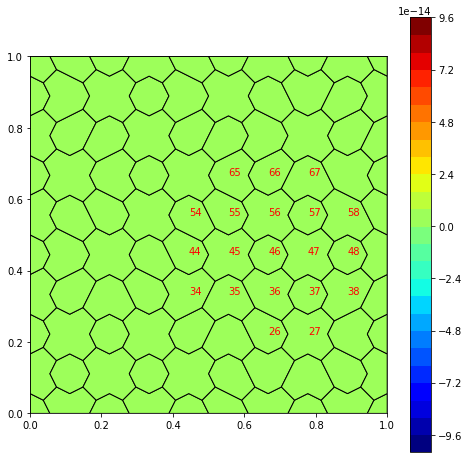

In [117]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from numpy import pi, sin, cos

def foo(x, y):
    return sin(2.*pi*x) * cos(2.*pi*y)

x0 = (0, 1)
y0 = (0, 1)

Nx, Ny = 10, 10
hx = (x0[1] - x0[0]) / (Nx-1)
hy = (y0[1] - y0[0]) / (Ny-1)

x = [x0[0] + i*hx for j in range(Ny) for i in range(Nx)]
y = [y0[0] + j*hy for j in range(Ny) for i in range(Nx)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
D = TriDual(x, y, T)


# Compute field variable
#------------------------------------------------------
D.add_field_variable('phi')
for i in D.intr_nodes + D.bdry_nodes:
    D.fieldVars['phi'][i] = 0.0#foo(D.x[i], D.y[i])
    

fig = plt.figure()
fig.set_size_inches(8,8)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
#D.plot_primary_grid(ax, fieldVar='phi')

D.plot_dual_grid(ax, fieldVar='phi', plotVertices=False)
ax.set_xlim(x0)
ax.set_ylim(y0)

# Plot neighborhood
NH = D.find_neighborhood(46, 10, 0.35)
for iNH in NH:
    ax.text(D.x[iNH], D.y[iNH], str(iNH), color='r')
    
plt.show()


# General Introduction to Least Squares Methods

For reference see:
- "An As-Short-As-Possible Introduction to the Least-Squares, Weighted Least Squares and Moving Least Squares Methods for Scattered Data Approximation and Interpolation" by Andrew Nealen

## Least Squares Approximation (LS)
Assume $N$ points at locations $\mathbf{x}_i$ in $R^d$ where $i \in [1,...,N]$.

We want to find a globally defined function $f(\mathbf{x})$, which approximates some given values $f_i$ at positions $\mathbf{x}_i$. 
Therefore, we define the error functional 
$$
J_{LS} = \sum_{i} || f(\mathbf{x}_i) - f_i || ^2 
$$
an the problem definition is to find $f$, such that it minimizes this error functional

$$
\text{min}\, (J_{LS}), \quad \text{for} \,f \in \Pi_m^d.
$$

Hereby $f$ is taken from $\Pi_m^d$, which denotes the space of polynomials of total degree $m$ in $d$ spatial dimensions.
The function $f(\mathbf{x})$ can also be written as:

$$
f(\mathbf{x}) = \mathbf{b}(\mathbf{x})^{T} \mathbf{c} =  \mathbf{b}(\mathbf{x}) \cdot \mathbf{c}
$$
with the polynomial basis vector $\mathbf{b}(\mathbf{x}) = [b_1(\mathbf{x}), ..., b_k(\mathbf{x})$ and the
vector of unknown coefficients $\mathbf{c} = [c_1, ..., c_k]$.

The minimization of $J_{LS}$ is realized through setting the partial derivatives of it to zero.
This leads to the following equation system:

$$
\underbrace{\sum_{i} \mathbf{b}(\mathbf{x_i}) \mathbf{b}(\mathbf{x_i})^{T}}_{A_{LS}} \mathbf{c} = \sum_i \mathbf{b}(\mathbf{x_i}) f_i
$$

which needs to be solved for $\mathbf{c}$..
The matrix $A_{LS}$ is called the least squares matrix and it must be inverted in order to determine the coefficient vector $\mathbf{c}$.


In [3]:
from math import factorial
import numpy as np

def poly_basis_2D(x, m):
    '''
    This function defines a the polynomial basis vector for a least squares approximation
    '''
    basis = [1]
    xi, yi = x[0],x[1]
    for i in range(1,m+1):
        for j in range(i+1):
            basis.append(xi**(i-j) * yi**(j) )
    return basis


def setup_least_squares_matrix(P, m):
    '''
    This function initializes the least squares matrix A for a given set of N points P
    for a polynomial degree m
    P = [(x1,y1), ..., (xN,yN)]
    '''
    k = int(factorial(2+m) / (factorial(m)*2)) # length of polynomial basis vector
    
    # Initialize matrix
    A = np.zeros([k,k])
    
    for xi in P:
        b = poly_basis_2D(xi, m)
        for j in range(k):
            for i in range(k):
                A[j][i] += b[j] * b[i]

    return A

def setup_right_hand_side(P, f, m):
    '''
    This function initializes the right hand side of the least squares problem 
    for a given set of N points P for a polynomial degree m
    P = [(x1,y1), ..., (xN,yN)]
    f = [f1, ..., fN]
    '''
    k = int(factorial(2+m) / (factorial(m)*2)) # length of polynomial basis vector
    # Initialize right hand side
    rhs = np.zeros(k)
    for iP, xi in enumerate(P):
        b = poly_basis_2D(xi, m)
        for i in range(k): rhs[i] += b[i]*f[iP]
    return rhs
        
    
    



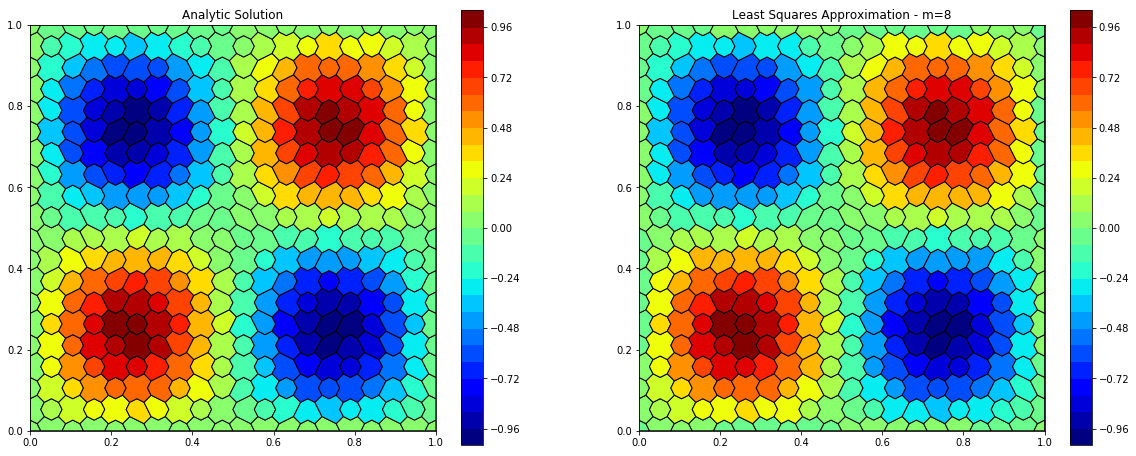

In [4]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from numpy import pi, sin, cos, sqrt
import numpy as np
from numpy import linalg

def foo(x, y):
    #return sqrt(((x-0.5)**2 + (y-0.5)**2))
    return sin(2*pi*x)*sin(2*pi*y)

x0 = (0, 1)
y0 = (0, 1)

Nx, Ny = 20, 20
hx = (x0[1] - x0[0]) / (Nx-1)
hy = (y0[1] - y0[0]) / (Ny-1)

x = [x0[0] + i*hx for j in range(Ny) for i in range(Nx)]
y = [y0[0] + j*hy for j in range(Ny) for i in range(Nx)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
D = TriDual(x, y, T)

# Compute analytic field variable
#------------------------------------------------------
D.add_field_variable('phi')      # Analytic Solution
D.add_field_variable('phi_LS') # Least Squares Solution
for i in D.intr_nodes + D.bdry_nodes:
    D.fieldVars['phi'][i] = foo(D.x[i], D.y[i])
    
# Perform least squares approximation over whole domain
#-----------------------------------------------------   
m = 8
P = [(D.x[i], D.y[i]) for i in range(D.Nvertices)]
f = [fi for fi in D.fieldVars['phi']]
A = setup_least_squares_matrix(P,m)
b = setup_right_hand_side(P,f,m)
# Invert matrix A
A_inv = linalg.inv(np.array(A))

# Compute coefficient vector
c = A_inv.dot(b)

# Compute least squares approximated funciton
for i in D.intr_nodes + D.bdry_nodes:
    basis = np.array(poly_basis_2D((D.x[i], D.y[i]), m))
    D.fieldVars['phi_LS'][i] = basis.dot(c)
    
fig = plt.figure()
fig.set_size_inches(20,8)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
#D.plot_primary_grid(ax, fieldVar='phi')
D.plot_dual_grid(ax1, fieldVar='phi')
D.plot_dual_grid(ax2, fieldVar='phi_LS')
ax1.set_xlim(x0)
ax1.set_ylim(y0)
ax2.set_xlim(x0)
ax2.set_ylim(y0)
ax1.set_title('Analytic Solution')
ax2.set_title('Least Squares Approximation - m=%d' % m)
plt.show()

# Weighted Least Squares Approximation (WLS)

For the weighted least squares approximation, the error functional is defined in a different manner:
$$
J_{WLS} = \sum_i \theta(d) ||f(\mathbf{x}_i - f_i||^2
$$
with the Euclidian distance 
$$
d_i = ||\overline{\mathbf{x}} - \mathbf{x}_i||
$$
between a fixed point $\overline{\mathbf{x}}$ and the positions of the data points $\mathbf{x}_i$.
Again, the problem definition is to minimize the error functional $J_{WLS}$ in order to get the best fit.
But this time the unknown coefficients are weighted by the distance to $\overline{\mathbf{x}}$ and are therefore a 
function of $\overline{\mathbf{x}}$.

The local weighted least squares approximation in $\overline{\mathbf{x}}$ is written as 
$$
f_{\overline{\mathbf{x}}}(\mathbf{x}) 
= \mathbf{b}(\mathbf{x})^{T} \mathbf{c}(\overline{\mathbf{x}})
=  \mathbf{b}(\mathbf{x}) \cdot \mathbf{c}(\overline{\mathbf{x}})
$$
and it is only defined within a distance $R$ around $\overline{\mathbf{x}}$.

## Definition of the Weighting Function
There are different possible choices for the weighting function. 
One choice is the Gaussian
$$
\theta(d) = e^{-d^2 / h^2}.
$$
Hereby $h$ is a spacing parameter which is used to smooth out small features in the data.

Another weighting function is the Wendland function:
$$
\theta(d) = \left(1-\frac{d}{h}\right)^4 \cdot \left(\frac{4}{h} + 1 \right).
$$
For this function the following properties hold:
$\theta(0) = 1$, $\theta(h) = 0$, $\theta'(h) = 0$ and $\theta''(h) = 0$.

Most authors use the following definition:
$$
\theta(d) = \frac{1}{d^2 + \epsilon^2}.
$$
Hereby $\epsilon$ is used as a fiiting parameter.

## System of Equations
The following system of equations has to be solved in order to obtain the coefficient vector $\mathbf{c}$:
$$
\underbrace{\sum_i \theta(d_i) \mathbf{b}(\mathbf{x}_i) \mathbf{b}(\mathbf{x}_i)^{T}}_{\mathbf{A}_{WLS}} \mathbf{c}(\overline{\mathbf{x}})
= \sum_i \theta(d_i) \mathbf{b}(\mathbf{x}_i) f_i
$$
with
$$
d_i = ||\overline{\mathbf{x}} - \mathbf{x}_i||
$$

## Global Approximation using a Partition of Unity (PU)

In this case, there is a set of $n$ points $\overline{\mathbf{x}}_j$ with $j \in [1,...,n]$, which are located in a parameter domain $\Omega$.
For every point in $\Omega$, at least one approximation polynomial is computed using the weighted least squares approach. 

These polynomials are weighted through the construction of a Partition of Unity (PU) from $\theta_j(\mathbf{x})

$$
\varphi_j(\mathbf{x}) = \frac{\theta_j(\mathbf{x})}{\sum_{k=1}^n \theta_k(\mathbf{x})}
$$

The global approximation function then becomes:

$$
f(\mathbf{x}) = \sum_j \varphi_j(\mathbf{x}) \mathbf{b}(\mathbf{x})^{T} \mathbf{c}(\overline{\mathbf{x}}_j)
$$

In [5]:
from math import factorial
import numpy as np
from numpy import sqrt, exp
from numpy import linalg


def poly_basis_2D(x, m):
    '''
    This function defines a the polynomial basis vector for a least squares approximation
    '''
    basis = [1]
    xi, yi = x[0],x[1]
    for i in range(1,m+1):
        for j in range(i+1):
            basis.append(xi**(i-j) * yi**(j) )
    return basis

def euclidian_dist_2D(x0, xi):
    '''
    This function defines the euclidian distance function for the weighted least squares approximation
    betwen a point xi of the scattered data and the fixed point x0
    '''
    return sqrt((x0[0]-xi[0])**2 + (x0[1]-xi[1])**2 )

def weighting_function_2D(d, h, wType='Gauss'):
    '''
    This function defines the weighting function for the least squares approximation
    '''
    if wType == 'Gauss':
        return exp(-(d*d) / (h*h) )
    elif wType == 'Wendland':
        return ((4./h)+1.) * (1. - (d/h))**4
    else:
        return 1. / (d*d + h*h)

    
def setup_weighted_least_squares_matrix(P, x0, h, m, wType='Gauss'):
    '''
    This function initializes the weighted least squares matrix A for a given set of N points P
    for a polynomial degree m around a point x0=(x0,y0))
    P = [(x1,y1), ..., (xN,yN)]
    '''
    k = int(factorial(2+m) / (factorial(m)*2)) # length of polynomial basis vector
    
    # Initialize matrix
    A = np.zeros([k,k])
    
    for xi in P:
        b = poly_basis_2D(xi, m)
        d = euclidian_dist_2D(x0, xi)
        theta = weighting_function_2D(d, h, wType)
        for j in range(k):
            for i in range(k):
                A[j][i] += theta * b[j] * b[i]
    return A


def setup_wls_right_hand_side(P, x0, h, f, m, wType='Gauss'):
    '''
    This function initializes the right hand side of the least squares problem 
    for a given set of N points P for a polynomial degree m
    P = [(x1,y1), ..., (xN,yN)]
    f = [f1, ..., fN]
    '''
    k = int(factorial(2+m) / (factorial(m)*2)) # length of polynomial basis vector
    # Initialize right hand side
    rhs = np.zeros(k)
    for iP, xi in enumerate(P):
        b = poly_basis_2D(xi, m)
        d = euclidian_dist_2D(x0, xi)
        theta = weighting_function_2D(d, h, wType)
        for i in range(k): rhs[i] += theta*b[i]*f[iP]
    return rhs

def construct_global_approximation_function(D, varName, x_PU, h, m, wType):
    '''
    This function constructs the global WLS approximation function for a given 
    unstrctured dataset with name "varName" on a dualmesh D
    '''
    P = [(D.x[i], D.y[i]) for i in range(D.Nvertices)]
    f = [fi for fi in D.fieldVars[varName]]
    f_glob = [0 for i in range(D.Nvertices)]
    
    for xi in x_PU:
        A = setup_weighted_least_squares_matrix(P, xi, h, m, wType)
        b = setup_wls_right_hand_side(P, xi, h, f, m, wType)
        # Invert matrix A
        A_inv = linalg.inv(np.array(A))
        # Compute coefficient vector
        c = A_inv.dot(b)

        # Compute least squares approximated function for current point 
        for i in D.intr_nodes + D.bdry_nodes:
            x_loc = (D.x[i], D.y[i])
            basis = np.array(poly_basis_2D(x_loc, m))
            d_loc = euclidian_dist_2D(xi, x_loc)
            theta_loc = weighting_function_2D(d_loc, h, wType)
            PU_sum = 0.0
            for x_j in x_PU:
                d_j = euclidian_dist_2D(x_j, x_loc)
                PU_sum += weighting_function_2D(d_j, h, wType)
            
            f_glob[i] += (theta_loc / PU_sum) *  basis.dot(c)
        
    return f_glob


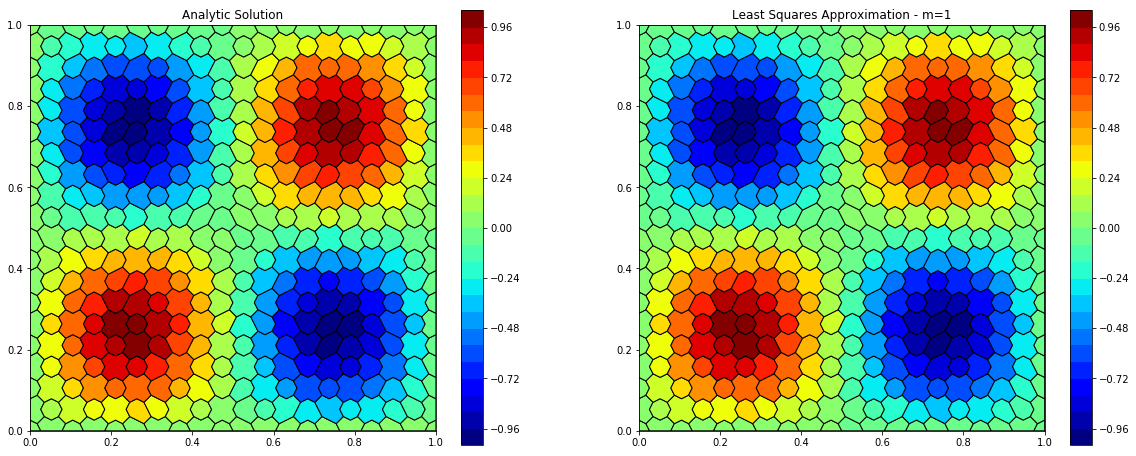

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from numpy import pi, sin, cos, sqrt
import numpy as np
from numpy import linalg

def foo(x, y):
    #return sqrt(((x-0.5)**2 + (y-0.5)**2))
    return sin(2*pi*x)*sin(2*pi*y)

x0 = (0, 1)
y0 = (0, 1)

Nx, Ny = 20, 20
hx = (x0[1] - x0[0]) / (Nx-1)
hy = (y0[1] - y0[0]) / (Ny-1)

x = [x0[0] + i*hx for j in range(Ny) for i in range(Nx)]
y = [y0[0] + j*hy for j in range(Ny) for i in range(Nx)]

# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
D = TriDual(x, y, T)

# Compute analytic field variable
#------------------------------------------------------
D.add_field_variable('phi')      # Analytic Solution
D.add_field_variable('phi_LS') # Least Squares Solution
for i in D.intr_nodes + D.bdry_nodes:
    D.fieldVars['phi'][i] = foo(D.x[i], D.y[i])
    
# Perform least squares approximation over whole domain
#-----------------------------------------------------   
x_PU = [(D.x[i], D.y[i]) for i in range(D.Nvertices)]
h = 1e-3
m = 1
wType = 'Default'

D.fieldVars['phi_LS'] = construct_global_approximation_function(D, 'phi', x_PU, h, m, wType)

fig = plt.figure()
fig.set_size_inches(20,8)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
#D.plot_primary_grid(ax, fieldVar='phi')
D.plot_dual_grid(ax1, fieldVar='phi')
D.plot_dual_grid(ax2, fieldVar='phi_LS')
ax1.set_xlim(x0)
ax1.set_ylim(y0)
ax2.set_xlim(x0)
ax2.set_ylim(y0)
ax1.set_title('Analytic Solution')
ax2.set_title('Least Squares Approximation - m=%d' % m)
plt.show()

# Moving Least Squares Approximation (MLS)

1) Take a cell $i$ and determine its neighborhood $S(i)$, such that there are $N_i$ neighbors in $S(i)$ and all neighbors are more or less located within a distance $h_i$ to node $\mathbf{x}_i$.

2) Choose a Kernel-Function $W(\mathbf{x}_j - \mathbf{x}_i, \kappa)$

3) Compute the matrix $\mathbf{A}_{MLS}^{(i)}$:
$$
\mathbf{A}_{MLS}^{(i)} 
= \sum_{j=1}^{N_i} W(\mathbf{x}_j - \mathbf{x}_i, \kappa) \mathbf{b}(\mathbf{x}_j) \mathbf{b}(\mathbf{x}_j)^{T}
= \sum_{j=1}^{N_i} W(\mathbf{x}_j - \mathbf{x}_i, \kappa)
\left\lgroup \matrix{b_1(\mathbf{x_j}) b_1(\mathbf{x_j})  & \cdots & b_1(\mathbf{x_j}) b_k(\mathbf{x_j}) \cr
                     \vdots & \ddots & \vdots \cr
                     b_k(\mathbf{x_j}) b_1(\mathbf{x_j})  & \cdots & b_k(\mathbf{x_j}) b_k(\mathbf{x_j}} 
                     \right\rgroup
$$

4) Compute the matrix $\mathbf{P}_{MLS}^{(i)}$:
$$
\mathbf{P}_{MLS}^{(i)} = 
\left\lgroup
\matrix{ 
W(\mathbf{x}_i - \mathbf{x}_1) b_1(\mathbf{x}_1) & \cdots & W(\mathbf{x}_i - \mathbf{x}_N) b_1(\mathbf{x}_N)
\cr\vdots & \ddots & \vdots \cr
W(\mathbf{x}_i - \mathbf{x}_1) b_k(\mathbf{x}_1) & \cdots & W(\mathbf{x}_i - \mathbf{x}_N) b_k(\mathbf{x}_N)
}
\right\rgroup
$$

5) Invert matrix $\mathbf{A}_{MLS}^{(i)}$ to determine $\left[\mathbf{A}_{MLS}^{(i)}\right]^{-1}$

6) The approximation function $\tilde{f}(\mathbf{x})$ around node $i$ can now be calculated through:
$$
\tilde{f}(\mathbf{x}) = 
\underbrace{\mathbf{b}(\mathbf{x}) \cdot \left[\mathbf{A}_{MLS}^{(i)}\right]^{-1} \cdot \mathbf{P}_{MLS}^{(i)}}_{= \mathbf{N}^{(i)}(\mathbf{x})} \cdot \mathbf{f}^{(i)}
$$
with the vector of the known values $\mathbf{f}^{(i)}$ of the stencil $S(i)$ around node $i$ and the grid dependent MLS shape function $\mathbf{N}^{(i)}(\mathbf{x})$.


In [ ]:
from math import factorial
import numpy as np
from numpy import sqrt, exp
from numpy import linalg

def poly_basis_2D(x, m):
    '''
    This function defines a the polynomial basis vector for a least squares approximation
    '''
    basis = [1]
    xi, yi = x[0],x[1]
    for i in range(1,m+1):
        for j in range(i+1):
            basis.append(xi**(i-j) * yi**(j) )
    return basis

def euclidian_dist_2D(x0, xi):
    '''
    This function defines the euclidian distance function for the weighted least squares approximation
    betwen a point xi of the scattered data and the fixed point x0
    '''
    return sqrt((x0[0]-xi[0])**2 + (x0[1]-xi[1])**2 )



In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from numpy import pi, sin, cos, sqrt
import numpy as np
from numpy import linalg

def foo(x, y):
    #return sqrt(((x-0.5)**2 + (y-0.5)**2))
    return sin(2*pi*x)*sin(2*pi*y)

x0 = (0, 1)
y0 = (0, 1)

Nx, Ny = 20, 20
hx = (x0[1] - x0[0]) / (Nx-1)
hy = (y0[1] - y0[0]) / (Ny-1)

x = [x0[0] + i*hx for j in range(Ny) for i in range(Nx)]
y = [y0[0] + j*hy for j in range(Ny) for i in range(Nx)]


# Create triangular mesh
#------------------------------------------------------
T = Triangulation(x, y)
D = TriDual(x, y, T)


# Compute analytic field variable
#------------------------------------------------------
D.add_field_variable('phi')      # Analytic Solution
D.add_field_variable('phi_MLS')  # Moving Least Squares Solution
for i in D.intr_nodes + D.bdry_nodes:
    D.fieldVars['phi'][i] = foo(D.x[i], D.y[i])

In [78]:
s = [1,3,2,4,5]
ind_sort = sorted(range(len(s)), key=lambda k: s[k])

print(ind_sort)

[0, 2, 1, 3, 4]


In [19]:
a.pop(a.index(1))

1

In [20]:
a

[2, 3]